# Data gen using markov chains with rule based memories.

Data gen using markov chains with rule based memories.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

In [40]:
class MarkovChain:
    
    cmap = {'home':'blue','work':'orange','shop':'green', 'education': 'red'}
    possible_states = {0: 'home', 1: 'work', 2: 'shop', 3: 'education'}
    mapper = {'home': 0, 'work': 1, 'shop': 2, 'education': 3}
    
    def __init__(self):
        self.time = 0 # first time step
        self.state = self.possible_states[np.random.choice(4, p=np.array([.995, 0.005, 0, 0]))]
        self.state_history = [(self.time, self.state)] # states visited
        
    def run(self, steps=24):
        for i in range(steps-1):
            self.step()
        return self
    
    def step(self):
        self.time += 1
        self.state_history.append((self.time, self.new_state()))

    def get_probs(self):
        p = self.transitions[self.state_history[-1][1]].loc[self.time].values
        p = p * self.repeat_adjustment() * self.duration_adjustment() * self.min_duration_adjustment()
        return p / sum(p)
    
    def new_state(self):
        return self.possible_states[np.random.choice(4, p=self.get_probs())]
    
    def repeat_adjustment(self):
        """
        Penalise activities based on how often they have been done.
        """
        tollerance = np.array([4, 2, 1, 1]) # tollerance for repeats before penalty
        sensitivity = np.array([1.2, 2, 2, 1.6]) # size of penalty
        
        activities = self.activities()
        counter = np.array([0, 0, 0, 0])
        for act in activities:
            counter[self.mapper[act]] += 1
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
    
    def duration_adjustment(self):
        """
        Penalise current activity based on duration.
        """
        tollerance = np.array([12, 6, 1, 6]) # tollerance for duration before penalty
        sensitivity = np.array([3, 2, 3, 3]) # size of penalty
        
        activities = self.activities()
        durations = self.durations()
        counter = np.array([0, 0, 0, 0])
        counter[self.mapper[activities[-1]]] = durations[-1]
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
    
    def min_duration_adjustment(self):
        """
        Penalise current activity based on duration.
        home work shop education
        """
        tollerance = np.array([3, 6, 1, 2]) # tollerance for min duration before penalty
        sensitivity = np.array([3, 3, 3, 3]) # size of penalty
        activities = self.activities()
        durations = self.durations()
        counter = np.array([0, 0, 0, 0])
        counter[self.mapper[activities[-1]]] = durations[-1]
        return np.clip(((tollerance - counter) + 2) * (counter > 0), 1, None) ** sensitivity
           
    def activities(self):
        """
        Transform hourly history: [(time, act), (time, act), ...] into an activity sequence, eg:
        activity durations: [act1, act2, ...].
        """
        activities = []
        previous = None
        for time, activity in self.state_history:
            if activity != previous:
                activities.append(activity)
                previous = activity
        return activities
    
    def durations(self):
        """
        Transform hourly history: [(time, act), (time, act), ...] into a duration sequence, eg:
        activity durations: [duration1, duration2, ...].
        """
        durations = []
        duration, previous = 0, None
        for time, activity in self.state_history:
            if activity == previous:
                duration += 1
            else:
                durations.append(duration)
                duration = 1
                previous = activity
        durations.append(duration)
        return durations
    
    def activity_sequence(self, pid=0):
        acts = ["<START>", self.state_history[0][1]]
        durations = [0]
        starts = [0,0]
        ends = [0]
        duration = 0
        for time, activity in self.state_history:
            if activity == acts[-1]:
                duration += 1
            else:
                acts.append(activity)
                durations.append(duration)
                starts.append(time)
                ends.append(time)
                duration = 1
                previous = activity
        durations.append(duration)
        ends.append(24)
        acts.append("<ENDS>")
        starts.append(ends[-1])
        durations.append(0)
        ends.append(24)
        return [(pid, i, a , s, e, d) for i, (a, s, e, d) in enumerate(zip(acts, starts, ends, durations))]
    
    def plot(self):
        t = pd.DataFrame(self.state_history)
        t.columns = ['x','activity']
        t['y'] = 1
        t['color'] = t.activity.map(self.cmap)
        plt.figure(figsize=(16,0.5))
        plt.scatter(t.x, t.y, color = t.color)
        plt.xticks([x for x in range(0,25)])
        plt.grid()


{'home': 'blue', 'work': 'orange', 'shop': 'green', 'education': 'red'}


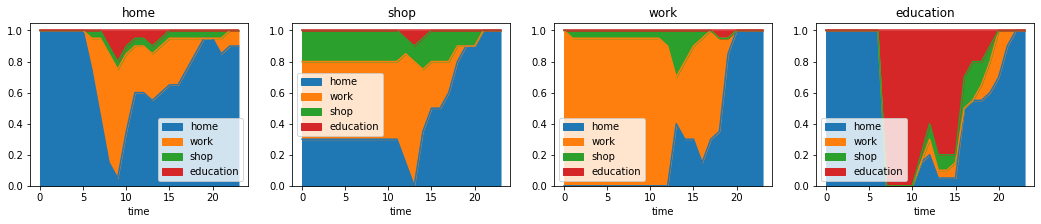

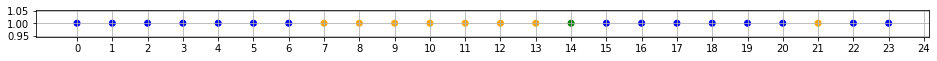

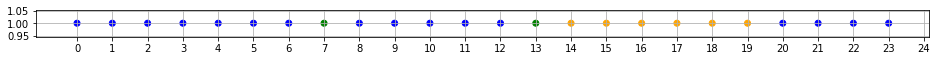

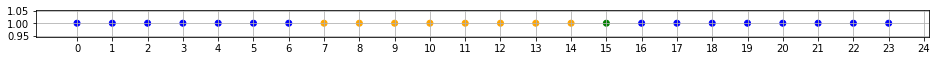

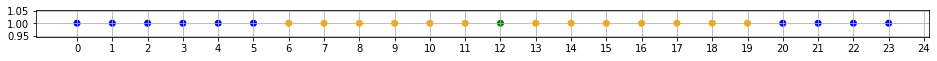

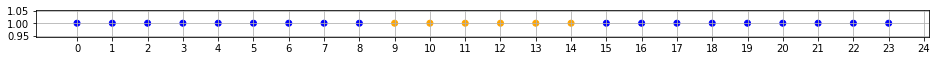

In [41]:
source = 'transitionsA'
transitionsA = {
    "home": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'home').set_index('time'),
    "shop": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'shop').set_index('time'),
    "work": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'work').set_index('time'),
    "education": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'education').set_index('time'),
}

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for i, (name, data) in enumerate(transitionsA.items()):
    data.plot.area(ax=axs[i], title=name, stacked = True)
    
class PersonA(MarkovChain):
    
    transitions = transitionsA
    
    def __init__(self):
        super().__init__()
        
print(PersonA.cmap)
for n in range(5):      
    chain = PersonA()
    chain.run()
    chain.plot()

{'home': 'blue', 'work': 'orange', 'shop': 'green', 'education': 'red'}


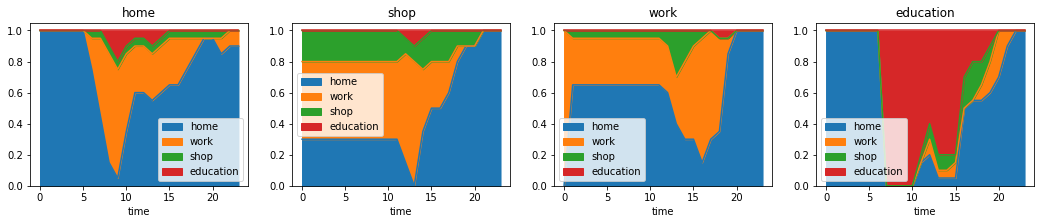

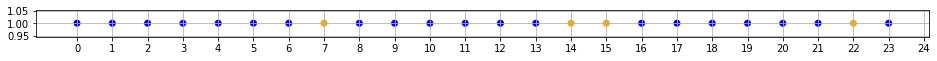

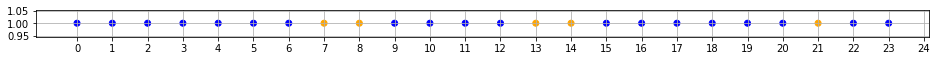

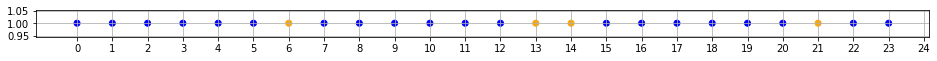

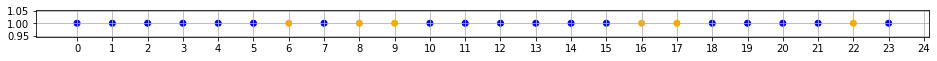

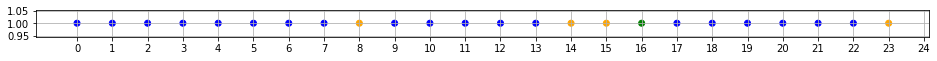

In [42]:
source = 'transitionsB'
transitionsB = {
    "home": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'home').set_index('time'),
    "shop": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'shop').set_index('time'),
    "work": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'work').set_index('time'),
    "education": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'education').set_index('time'),
}

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for i, (name, data) in enumerate(transitionsB.items()):
    data.plot.area(ax=axs[i], title=name, stacked = True)
    
class PersonB(MarkovChain):
    
    transitions = transitionsB
    
    def __init__(self):
        super().__init__()
        
    def repeat_adjustment(self):
        """
        Penalise activities based on how often they have been done.
        home work shop education
        """
        tollerance = np.array([4, 4, 1, 0]) # tollerance for repeats before penalty
        sensitivity = np.array([1.2, 2, 2, 2]) # size of penalty
        activities = self.activities()
        counter = np.array([0, 0, 0, 0])
        for act in activities:
            counter[self.mapper[act]] += 1
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
    
    def duration_adjustment(self):
        """
        Penalise current activity based on duration.
        home work shop education
        """
        tollerance = np.array([6, 2, 0, 0]) # tollerance for duration before penalty
        sensitivity = np.array([3, 3, 3, 3]) # size of penalty
        activities = self.activities()
        durations = self.durations()
        counter = np.array([0, 0, 0, 0])
        counter[self.mapper[activities[-1]]] = durations[-1]
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
    
    def min_duration_adjustment(self):
        """
        Penalise current activity based on duration.
        home work shop education
        """
        tollerance = np.array([3, 1, 1, 2]) # tollerance for min duration before penalty
        sensitivity = np.array([3, 3, 3, 3]) # size of penalty
        activities = self.activities()
        durations = self.durations()
        counter = np.array([0, 0, 0, 0])
        counter[self.mapper[activities[-1]]] = durations[-1]
        return np.clip(((tollerance - counter) + 2) * (counter > 0), 1, None) ** sensitivity
        
        
print(PersonB.cmap)
for n in range(5):      
    chain = PersonB()
    chain.run()
    chain.plot()


{'home': 'blue', 'work': 'orange', 'shop': 'green', 'education': 'red'}


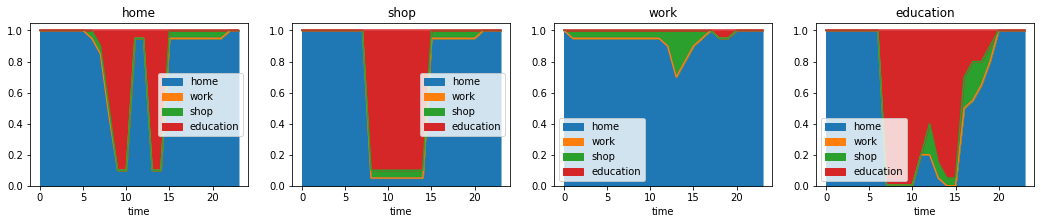

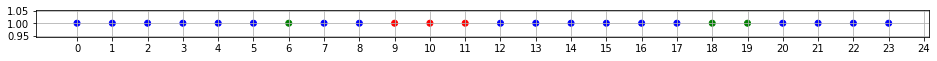

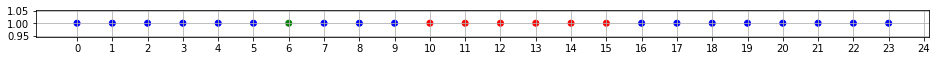

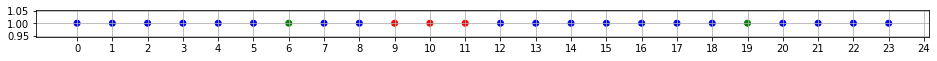

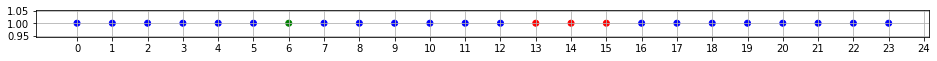

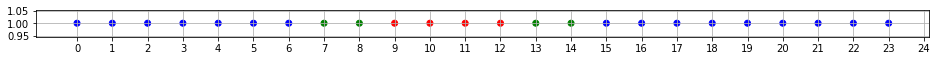

In [43]:
source = 'transitionsC'
transitionsC = {
    "home": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'home').set_index('time'),
    "shop": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'shop').set_index('time'),
    "work": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'work').set_index('time'),
    "education": pd.read_excel(f'Data/{source}.xlsm', sheet_name = 'education').set_index('time'),
}

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for i, (name, data) in enumerate(transitionsC.items()):
    data.plot.area(ax=axs[i], title=name, stacked = True)
    
class PersonC(MarkovChain):
    
    transitions = transitionsC
    
    def __init__(self):
        super().__init__()
        
    def repeat_adjustment(self):
        """
        Penalise activities based on how often they have been done.
        home work shop education
        """
        tollerance = np.array([5, 1, 5, 1]) # tollerance for repeats before penalty
        sensitivity = np.array([3, 2, 2, 3]) # size of penalty
        activities = self.activities()
        counter = np.array([0, 0, 0, 0])
        for act in activities:
            counter[self.mapper[act]] += 1
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
    
    def duration_adjustment(self):
        """
        Penalise current activity based on duration.
        home work shop education
        """
        tollerance = np.array([6, 1, 2, 6]) # tollerance for duration before penalty
        sensitivity = np.array([3, 3, 3, 3]) # size of penalty
        activities = self.activities()
        durations = self.durations()
        counter = np.array([0, 0, 0, 0])
        counter[self.mapper[activities[-1]]] = durations[-1]
        return 1 / (np.clip((counter - tollerance + 2), 1, None) ** sensitivity)
        
        
print(PersonC.cmap)
for n in range(5):      
    chain = PersonC()
    chain.run()
    chain.plot()


In [45]:
class Population:
    
    def __init__(self, size, p=(0.7, 0.1, 0.2)):
        print("NEW POP SIZE", size, p)
        self.size = size
        self.histories = []
        self.log = []
        self.candidates = [PersonA, PersonB, PersonC]
        self.p = p
        for n in range(size):
            chain = self.candidates[np.random.choice(3, p=self.p)]().run()
            self.histories.extend(chain.state_history)
            self.log.extend(chain.activity_sequence(n))
            
    def activity_sequences(self, encoded=False):
        df = pd.DataFrame(self.log, columns=['pid', 'seq', 'act', 'start', 'end', 'duration'])
        if not encoded: # filter out START and END ENCODINGS
            return df.loc[df.act.isin(["<START>", "<ENDS>"]) == False]
        return df
    
    def state_histories(self):
        return pd.DataFrame(self.histories, columns=['time', 'act'])
    
    def time_bins(self):
        df = self.state_histories().groupby('time')['act'].value_counts().unstack(level=1).fillna(0)
        for c in list(MarkovChain.cmap.keys()):
            if c not in df.columns:
                df[c] = 0
        return df.loc[:, list(MarkovChain.cmap.keys())]

    def plot_bins_on(self, ax):
        self.time_bins().plot(kind='area', color=MarkovChain.cmap.values(), ax=ax)    
            
    def plot_bins(self, figsize=(12,5)):
        fig, ax = plt.subplots(1,  figsize=figsize)
        self.plot_bins_on(ax)
        plt.title(f'Activity Location by hour of the day, {self.p}')
        plt.xticks([x for x in range(0,25)])
        plt.grid()
        plt.show()

NEW POP SIZE 10 (1, 0, 0)


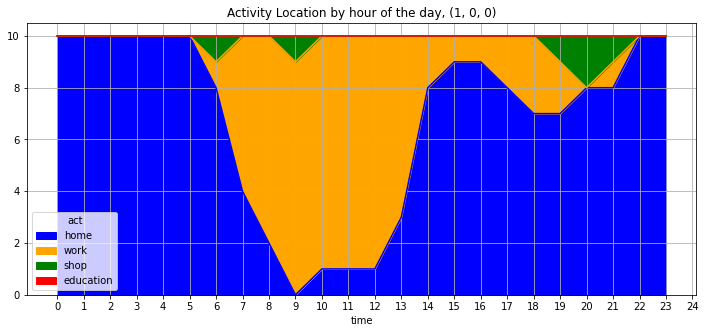

NEW POP SIZE 10 (0, 1, 0)


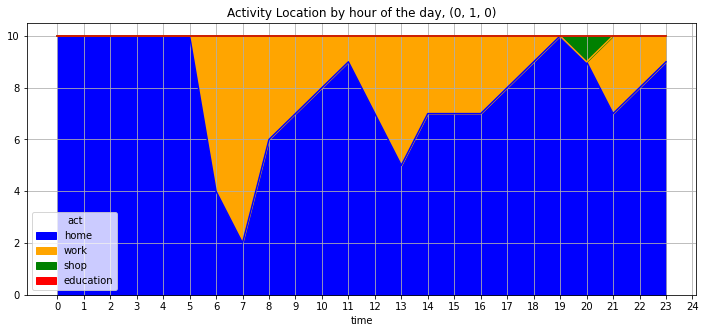

NEW POP SIZE 10 (0, 0, 1)


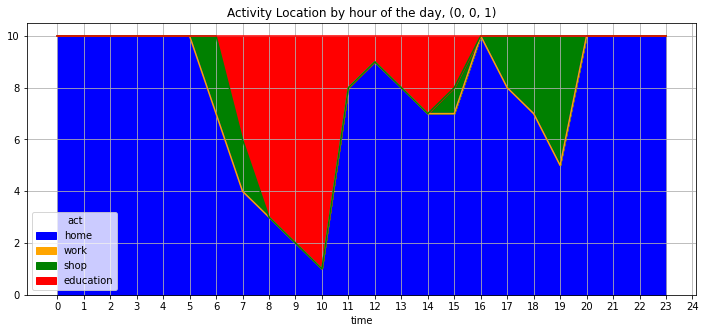

In [46]:
Population(10, p=(1,0,0)).plot_bins()
Population(10, p=(0,1,0)).plot_bins()
Population(10, p=(0,0,1)).plot_bins()

NEW POP SIZE 10 (0.7, 0.1, 0.2)
NEW POP SIZE 20 (0.7, 0.1, 0.2)
NEW POP SIZE 30 (0.7, 0.1, 0.2)
NEW POP SIZE 40 (0.7, 0.1, 0.2)
NEW POP SIZE 50 (0.7, 0.1, 0.2)
NEW POP SIZE 60 (0.7, 0.1, 0.2)


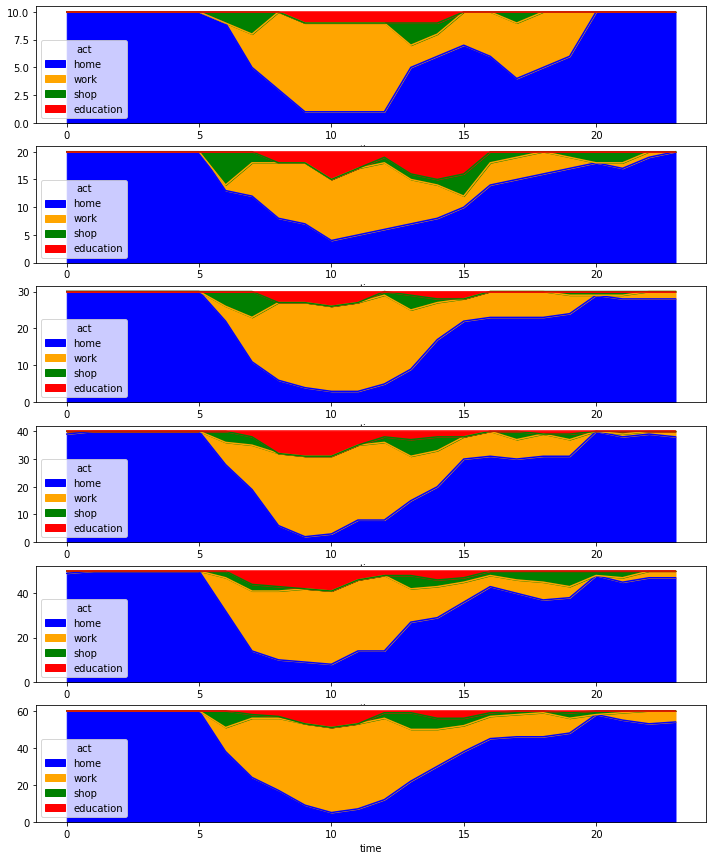

In [47]:
plots = 6
fig, axs = plt.subplots(plots,  figsize=(12, 15))
for i in range(plots):
    pop = (i+1)*10
    Population(pop, p=(.7,.1,.2)).plot_bins_on(axs[i])

In [48]:
Population(10000).activity_sequences(encoded=True).set_index('pid').to_csv("Data/test.csv")

NEW POP SIZE 10000 (0.7, 0.1, 0.2)
